In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

## Load the Dataset

In [2]:
file_path = r"C:\Users\NITESH NAMDEV\Nexthike projects\Project_8  Dynamic Workforce Insights and Recommendation Platform\all_upwork_jobs_2024-02-07-2024-03-24.csv"
df = pd.read_csv(file_path)

In [3]:
print(df)

                                                    title  \
0       Experienced Media Buyer For Solar Pannel and R...   
1                                    Full Stack Developer   
2                                         SMMA Bubble App   
3                  Talent Hunter Specialized in Marketing   
4                                           Data Engineer   
...                                                   ...   
244823  Need Facebook advertising experts to launch pr...   
244824          Digital/Telemarketing/Sales/OutSide Sales   
244825                           WordPress Template Edits   
244826            ELEMENTOR PRO For quick fix (Wordpress)   
244827              Creating a UGC Ad for Our Mobile Game   

                                                     link  \
0       https://www.upwork.com/jobs/Experienced-Media-...   
1       https://www.upwork.com/jobs/Full-Stack-Develop...   
2       https://www.upwork.com/jobs/SMMA-Bubble-App_%7...   
3       https://www.upw

In [4]:
print(df.head())

                                               title  \
0  Experienced Media Buyer For Solar Pannel and R...   
1                               Full Stack Developer   
2                                    SMMA Bubble App   
3             Talent Hunter Specialized in Marketing   
4                                      Data Engineer   

                                                link  \
0  https://www.upwork.com/jobs/Experienced-Media-...   
1  https://www.upwork.com/jobs/Full-Stack-Develop...   
2  https://www.upwork.com/jobs/SMMA-Bubble-App_%7...   
3  https://www.upwork.com/jobs/Talent-Hunter-Spec...   
4  https://www.upwork.com/jobs/Data-Engineer_%7E0...   

              published_date  is_hourly  hourly_low  hourly_high  budget  \
0  2024-02-17 09:09:54+00:00      False         NaN          NaN   500.0   
1  2024-02-17 09:09:17+00:00      False         NaN          NaN  1100.0   
2  2024-02-17 09:08:46+00:00       True        10.0         30.0     NaN   
3  2024-02-17 09:08:08

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244828 entries, 0 to 244827
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   title           244827 non-null  object 
 1   link            244827 non-null  object 
 2   published_date  244828 non-null  object 
 3   is_hourly       244828 non-null  bool   
 4   hourly_low      102422 non-null  float64
 5   hourly_high     98775 non-null   float64
 6   budget          103891 non-null  float64
 7   country         239751 non-null  object 
dtypes: bool(1), float64(3), object(4)
memory usage: 13.3+ MB
None


In [6]:
df.isnull().sum()

title                  1
link                   1
published_date         0
is_hourly              0
hourly_low        142406
hourly_high       146053
budget            140937
country             5077
dtype: int64

In [7]:
# Fill missing hourly values with the median directly
df['hourly_low'].fillna(df['hourly_low'].median(), inplace=True)
df['hourly_high'].fillna(df['hourly_high'].median(), inplace=True)

# Calculate the budget for hourly jobs
df['budget'] = np.where(df['is_hourly'], (df['hourly_low'] + df['hourly_high']) / 2, df['budget'])

# Fill missing country values with 'Unknown'
df['country'].fillna('Unknown', inplace=True)

# Check and display the result after handling missing values
print(df[['hourly_low', 'hourly_high', 'budget', 'country']].head())


   hourly_low  hourly_high  budget        country
0        15.0         30.0   500.0        Unknown
1        15.0         30.0  1100.0  United States
2        10.0         30.0    20.0  United States
3        15.0         30.0    22.5  United States
4        15.0         30.0   650.0          India


In [8]:
df.dropna(inplace=True)

In [9]:
df.isnull().sum()

title             0
link              0
published_date    0
is_hourly         0
hourly_low        0
hourly_high       0
budget            0
country           0
dtype: int64

In [10]:
df.shape

(244827, 8)

In [11]:
df.duplicated().sum()

0

In [12]:
# Clean and Tokenize Job Titles

# Function to clean job titles
def clean_text_alternative(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    stop_words = set(stopwords.words('english'))  # Get English stopwords
    # Tokenize the text and filter out stopwords
    return ' '.join([word for word in text.split() if word not in stop_words])

# Apply the cleaning function to the 'title' column
df['Cleaned Job Title'] = df['title'].apply(clean_text_alternative)

# Display the cleaned job titles
print(df[['title', 'Cleaned Job Title']].head())

                                               title  \
0  Experienced Media Buyer For Solar Pannel and R...   
1                               Full Stack Developer   
2                                    SMMA Bubble App   
3             Talent Hunter Specialized in Marketing   
4                                      Data Engineer   

                                   Cleaned Job Title  
0  experienced media buyer solar pannel roofing i...  
1                               full stack developer  
2                                    smma bubble app  
3                talent hunter specialized marketing  
4                                      data engineer  


In [13]:
keywords = df['Cleaned Job Title'].str.split().explode()
keyword_counts = Counter(keywords)

In [14]:
from collections import Counter

# Tokenize job titles and count keyword frequencies using apply
keywords = df['Cleaned Job Title'].apply(lambda x: x.split()).explode()
keyword_counts = Counter(keywords)

# Display the results
print(keyword_counts)


Counter({'needed': 17571, 'website': 16688, 'developer': 15678, 'expert': 14910, 'video': 13822, 'design': 12984, 'designer': 12603, 'need': 10223, 'amp': 9276, 'specialist': 8939, 'looking': 8730, 'marketing': 8250, 'media': 8211, 'app': 8094, 'editor': 7758, 'youtube': 7585, 'social': 7554, 'data': 7036, 'create': 6836, 'content': 6723, 'manager': 6669, 'google': 6632, 'wordpress': 6595, 'assistant': 6490, 'web': 6462, 'business': 6100, 'project': 6066, 'development': 5899, 'logo': 5629, 'ads': 5378, 'shopify': 5304, 'graphic': 5246, 'seo': 4934, 'help': 4892, 'product': 4827, 'sales': 4674, 'writer': 4644, 'company': 4410, 'virtual': 4370, 'experienced': 4337, 'page': 4256, 'english': 4171, 'build': 4078, 'email': 3876, 'lead': 3721, 'ai': 3697, 'facebook': 3668, 'brand': 3433, 'channel': 3359, 'new': 3195, 'seeking': 3135, 'ecommerce': 3033, 'creation': 2950, 'creator': 2932, 'site': 2915, 'research': 2852, 'management': 2813, 'mobile': 2791, 'digital': 2772, 'generation': 2712, 'e

In [15]:
# Convert the keywords list to a pandas Series and get the value counts
top_keywords = pd.Series(keywords).value_counts().head(20)

# Display the top 20 keywords and their counts
print("Top Keywords:", top_keywords)

Top Keywords: needed        17571
website       16688
developer     15678
expert        14910
video         13822
design        12984
designer      12603
need          10223
amp            9276
specialist     8939
looking        8730
marketing      8250
media          8211
app            8094
editor         7758
youtube        7585
social         7554
data           7036
create         6836
content        6723
Name: Cleaned Job Title, dtype: int64


In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Initialize the CountVectorizer and transform the data into a term-frequency matrix
count_vectorizer = CountVectorizer(max_features=100)
count_matrix = count_vectorizer.fit_transform(df['Cleaned Job Title'])

# Apply TfidfTransformer to convert the term-frequency matrix to a TF-IDF matrix
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(count_matrix)

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())

# Display the resulting DataFrame
print(tfidf_df.head())

   account   ad  ads  agency   ai  amazon  amp  api  app  application  ...  \
0      0.0  0.0  0.0     0.0  0.0     0.0  0.0  0.0  0.0          0.0  ...   
1      0.0  0.0  0.0     0.0  0.0     0.0  0.0  0.0  0.0          0.0  ...   
2      0.0  0.0  0.0     0.0  0.0     0.0  0.0  0.0  1.0          0.0  ...   
3      0.0  0.0  0.0     0.0  0.0     0.0  0.0  0.0  0.0          0.0  ...   
4      0.0  0.0  0.0     0.0  0.0     0.0  0.0  0.0  0.0          0.0  ...   

   using  video  videos  virtual  web  website  wordpress  work  writer  \
0    0.0    0.0     0.0      0.0  0.0      0.0        0.0   0.0     0.0   
1    0.0    0.0     0.0      0.0  0.0      0.0        0.0   0.0     0.0   
2    0.0    0.0     0.0      0.0  0.0      0.0        0.0   0.0     0.0   
3    0.0    0.0     0.0      0.0  0.0      0.0        0.0   0.0     0.0   
4    0.0    0.0     0.0      0.0  0.0      0.0        0.0   0.0     0.0   

   youtube  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  

[

In [17]:
import numpy as np

# Sum the TF-IDF scores along the columns (axis=0) and sort the values
tfidf_scores = pd.Series(np.array(tfidf_matrix.sum(axis=0)).flatten(), 
                         index=tfidf_df.columns).sort_values(ascending=False)

# Display the top 20 keywords with the highest TF-IDF scores
print("Top TF-IDF Keywords:\n", tfidf_scores.head(20))

Top TF-IDF Keywords:
 website       9772.837588
needed        9444.632479
developer     9281.090132
expert        8639.339049
design        8245.233054
video         7653.085025
designer      7598.466970
need          6453.582390
specialist    5483.635873
looking       5325.399726
amp           5070.298583
app           4962.727481
marketing     4697.204410
editor        4559.897254
data          4480.035515
create        4432.013168
youtube       4350.570670
wordpress     4248.659031
media         4217.221172
assistant     4152.953035
dtype: float64


## Task 1: Job Title Keywords vs. Salaries

In [18]:
# Initialize an empty DataFrame to store the results
keyword_salary_data = []

# Iterate through the keywords in tfidf_scores
for keyword in tfidf_scores.index:
    # Filter the relevant job titles
    relevant_jobs = df[df['Cleaned Job Title'].str.contains(keyword, na=False)]
    
    if not relevant_jobs.empty:
        # Calculate the average salary and get the top 3 URLs
        avg_salary = relevant_jobs['budget'].mean()
        example_urls = relevant_jobs['link'].head(3).tolist()
        
        # Append the result to the list
        keyword_salary_data.append({
            'Keyword': keyword,
            'Average Salary': avg_salary,
            'Example URLs': ', '.join(example_urls)
        })

# Convert the result to a DataFrame
keyword_salary_df = pd.DataFrame(keyword_salary_data).sort_values(by='Average Salary', ascending=False)

# Preview the keyword-salary mapping
print(keyword_salary_df.head(10))


        Keyword  Average Salary  \
60      digital     1852.522328   
29        sales     1832.128437   
78         full     1196.328125   
77          job     1146.074854   
84      account      963.945363   
99        stack      905.407966   
27  development      869.190496   
42        build      800.367362   
65  application      764.515187   
51      seeking      701.930362   

                                         Example URLs  
60  https://www.upwork.com/jobs/Digital-Marketing-...  
29  https://www.upwork.com/jobs/Digital-Marketing-...  
78  https://www.upwork.com/jobs/Full-Stack-Develop...  
77  https://www.upwork.com/jobs/Create-job-offers-...  
84  https://www.upwork.com/jobs/Professional-Debt-...  
99  https://www.upwork.com/jobs/Full-Stack-Develop...  
27  https://www.upwork.com/jobs/Transport-Transpor...  
42  https://www.upwork.com/jobs/Build-standalone-P...  
65  https://www.upwork.com/jobs/Flutter-applicatio...  
51  https://www.upwork.com/jobs/Seeking-Creative-V... 

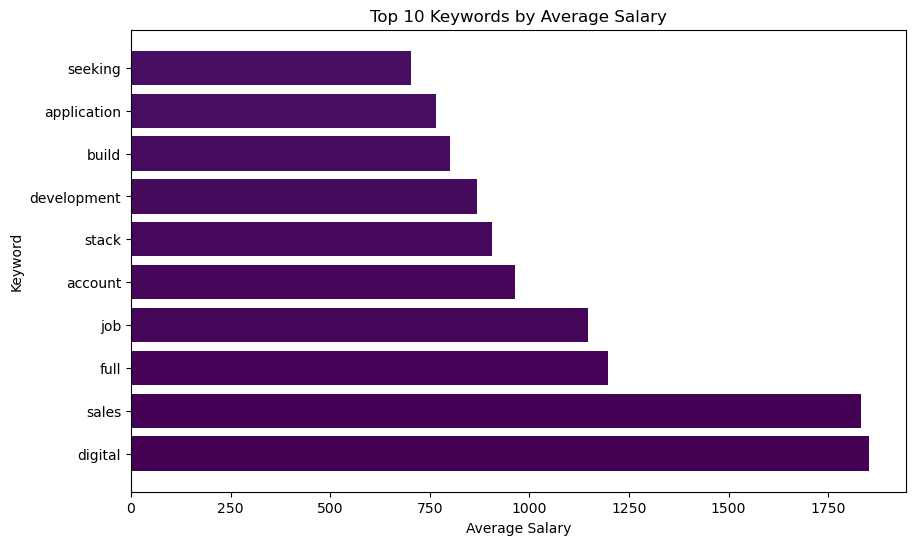

In [19]:
import matplotlib.pyplot as plt

# Get the top 10 keywords by average salary
top_10_keywords = keyword_salary_df.head(10)

# Plotting using matplotlib
plt.figure(figsize=(10, 6))
plt.barh(top_10_keywords['Keyword'], top_10_keywords['Average Salary'], color=plt.cm.viridis(range(10)))

# Add titles and labels
plt.title('Top 10 Keywords by Average Salary')
plt.xlabel('Average Salary')
plt.ylabel('Keyword')

# Show the plot
plt.show()

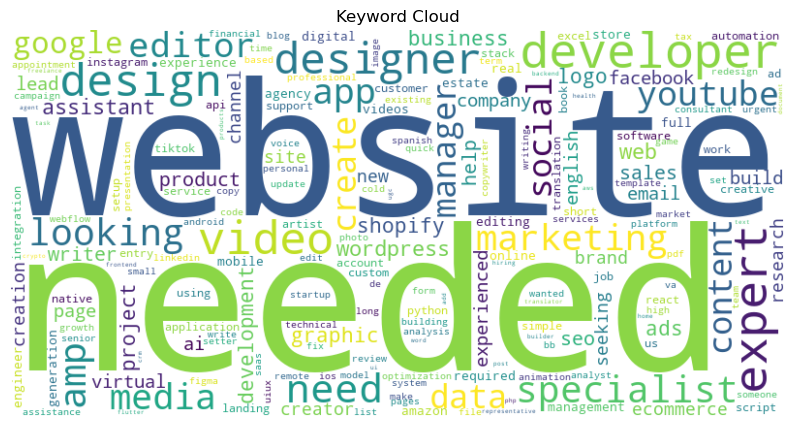

In [20]:
from PIL import Image
import numpy as np

# Generate the word cloud (same as original, just using PIL for display)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)

# Convert the WordCloud image to an array for use with matplotlib
image_array = np.array(wordcloud)

# Plotting the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(image_array, interpolation='bilinear')
plt.axis('off')
plt.title('Keyword Cloud')
plt.show()

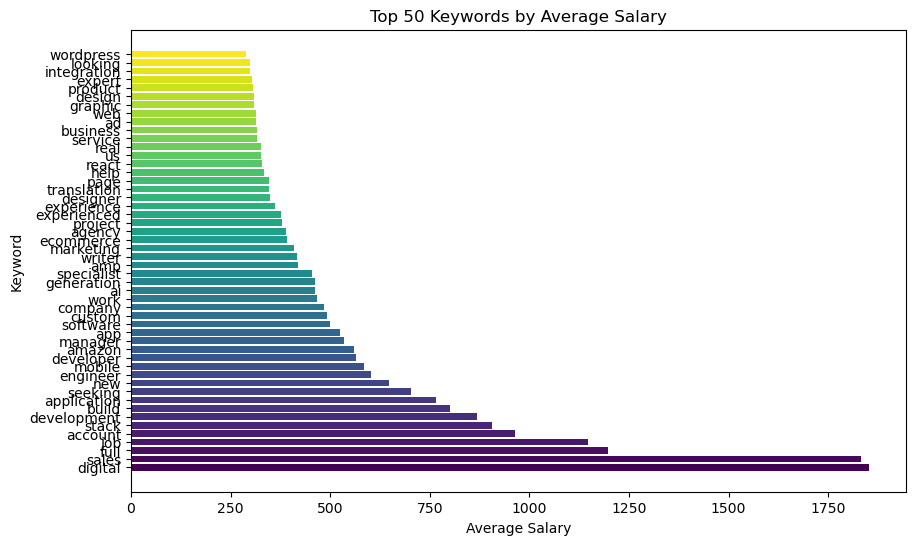

In [21]:
import matplotlib.pyplot as plt

# Get the top 50 keywords by average salary
top_50_keywords = keyword_salary_df.head(50)

# Plotting using matplotlib
plt.figure(figsize=(10, 6))
plt.barh(top_50_keywords['Keyword'], top_50_keywords['Average Salary'], color=plt.cm.viridis(np.linspace(0, 1, 50)))

# Add titles and labels
plt.title('Top 50 Keywords by Average Salary')
plt.xlabel('Average Salary')
plt.ylabel('Keyword')

# Show the plot
plt.show()

In [22]:
# Using the 'open' function for saving the DataFrame to CSV
with open('keyword_salary_analysis_with_urls.csv', mode='w', newline='', encoding='utf-8') as file:
    keyword_salary_df.to_csv(file, index=False)

In [23]:
import plotly.graph_objects as go

# Add URLs to the DataFrame for hover text
top_10_keywords['URLs'] = top_10_keywords['Example URLs']

# Create an interactive bar plot using plotly.graph_objects
fig = go.Figure(data=[go.Bar(
    x=top_10_keywords['Average Salary'],
    y=top_10_keywords['Keyword'],
    orientation='h',
    hovertext=top_10_keywords['URLs'],  # Display URLs on hover
    hoverinfo='text'
)])

# Update the layout for the plot
fig.update_layout(
    title='Top 10 Keywords by Average Salary',
    xaxis_title='Average Salary',
    yaxis_title='Keyword',
    template='plotly',
)

# Show the plot
fig.show()

In [24]:
import plotly.graph_objects as go

# Prepare the data: Top 15 keywords by average salary
top_keywords = keyword_salary_df.head(15)

# Add custom hover text
top_keywords['Hover Text'] = (
    'Keyword: ' + top_keywords['Keyword'] +
    '<br>Average Salary: $' + top_keywords['Average Salary'].round(2).astype(str) +
    '<br>Example URLs: ' + top_keywords['Example URLs']
)

# Create the interactive bar chart using go.Bar()
fig = go.Figure(data=[go.Bar(
    x=top_keywords['Keyword'],
    y=top_keywords['Average Salary'],
    text=top_keywords['Average Salary'],
    hovertext=top_keywords['Hover Text'],  # Display custom hover text
    hoverinfo='text',
    marker=dict(
        color=top_keywords['Average Salary'],
        colorscale='Viridis'
    )
)])

# Customize the layout for better visuals
fig.update_layout(
    title='Top Keywords by Average Salary',
    title_font_size=20,
    title_font_color='darkblue',
    title_x=0.5,  # Center the title
    xaxis_title='Keywords',
    yaxis_title='Average Salary ($)',
    xaxis_tickangle=-45,
    template='plotly_white',
)

# Display the figure
fig.show()

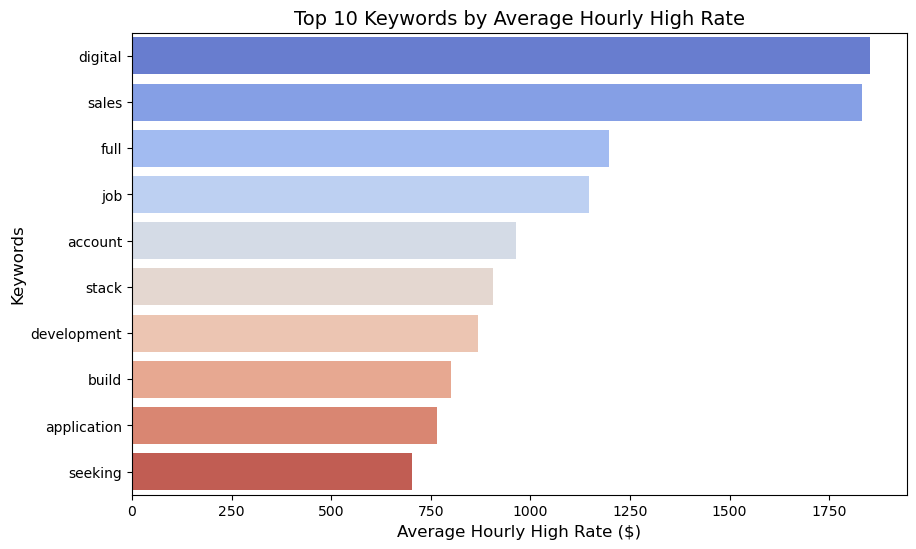

In [25]:
# Visualize top 10 keywords with the highest average hourly rates
plt.figure(figsize=(10, 6))
sns.barplot(
    y=top_10_keywords['Keyword'][:10],
    x=top_10_keywords['Average Salary'][:10],
    palette="coolwarm",
    orient="h"
)
plt.title("Top 10 Keywords by Average Hourly High Rate", fontsize=14)
plt.xlabel("Average Hourly High Rate ($)", fontsize=12)
plt.ylabel("Keywords", fontsize=12)
plt.show()

## Task 2: Emerging Job Categories

In [26]:
df.head(10)

title  \
0  Experienced Media Buyer For Solar Pannel and R...   
1                               Full Stack Developer   
2                                    SMMA Bubble App   
3             Talent Hunter Specialized in Marketing   
4                                      Data Engineer   
5               SEO for Portuguese Psychologist site   
6                   Want to fix the WordPress Plugin   
7  need Portuguese writers who can understand and...   
8  Looker Studio Dashboard for Leadgen and E-Comm...   
9  PHP/HTML/CSS WordPress Developer Needed for We...   

                                                link  \
0  https://www.upwork.com/jobs/Experienced-Media-...   
1  https://www.upwork.com/jobs/Full-Stack-Develop...   
2  https://www.upwork.com/jobs/SMMA-Bubble-App_%7...   
3  https://www.upwork.com/jobs/Talent-Hunter-Spec...   
4  https://www.upwork.com/jobs/Data-Engineer_%7E0...   
5  https://www.upwork.com/jobs/SEO-for-Portuguese...   
6  https://www.upwork.com/jobs/Want-fix-the-WordP...   
7  https://www.upwork.com/jobs/need-Portuguese-wr...   
8  https://www.upwork.com/jobs/Looker-Studio-Dash...   
9  https://www.upwork.com/jobs/PHP-HTML-CSS-WordP...   

              published_date  is_hourly  hourly_low  hourly_high  budget  \
0  2024-02-17 09:09:54+00:00      False        15.0         30.0   500.0   
1  2024-02-17 09:09:17+00:00      False        15.0         30.0  1100.0   
2  2024-02-17 09:08:46+00:00       True        10.0         30.0    20.0   
3  2024-02-17 09:08:08+00:00       True        15.0         30.0    22.5   
4  2024-02-17 09:07:42+00:00      False        15.0         30.0   650.0   
5  2024-02-17 09:07:41+00:00       True        15.0         30.0    22.5   
6  2024-02-17 09:07:27+00:00      False        15.0         30.0     5.0   
7  2024-02-17 09:07:05+00:00       True         7.0         22.0    14.5   
8  2024-02-17 09:06:24+00:00       True        15.0         30.0    22.5   
9  2024-02-17 09:06:21+00:00      False        15.0         30.0   500.0   

         country                                  Cleaned Job Title  
0        Unknown  experienced media buyer solar pannel roofing i...  
1  United States                               full stack developer  
2  United States                                    smma bubble app  
3  United States                talent hunter specialized marketing  
4          India                                      data engineer  
5       Portugal                   seo portuguese psychologist site  
6          India                          want fix wordpress plugin  
7          India  need portuguese writers understand write portu...  
8        Germany  looker studio dashboard leadgen ecommerce tool...  
9         Canada  phphtmlcss wordpress developer needed website ...

In [27]:
import re

def map_to_category(title):
    title = title.lower()

    categories = {
        'Software Development': ['developer', 'software', 'engineer', 'programmer', 'devops', 'backend', 'frontend', 'full stack'],
        'Data Science': ['data', 'machine learning', 'ai', 'analytics', 'science', 'big data'],
        'Design': ['designer', 'ui', 'ux', 'graphic', 'visual', 'motion'],
        'Marketing': ['marketing', 'seo', 'advertising', 'campaign', 'social media'],
        'Writing': ['writer', 'content', 'editor', 'author', 'translator', 'copywriter'],
        'Project Management': ['manager', 'management', 'pm', 'product owner', 'scrum'],
        'Customer Support': ['customer', 'support', 'service', 'client', 'helpdesk'],
        'Sales': ['sales', 'business development', 'account', 'growth'],
        'Finance': ['finance', 'accounting', 'bookkeeper', 'financial'],
        'Legal': ['legal', 'lawyer', 'attorney', 'paralegal'],
        'Education': ['teacher', 'trainer', 'tutor', 'educator']
    }

    # Loop through categories and check for matches
    for category, keywords in categories.items():
        if any(re.search(r'\b' + re.escape(word) + r'\b', title) for word in keywords):
            return category

    return 'Other'

In [28]:
# Initialize an empty list to store categories
categories_list = []

# Iterate over each job title and map to category
for title in df['title']:
    category = map_to_category(title)
    categories_list.append(category)

# Assign the categories to a new column
df['Category'] = categories_list

# Get the count of each category using groupby and size
category_counts = df.groupby('Category').size()

# Display the result
print(category_counts)

Category
Customer Support          4031
Data Science             10543
Design                   15319
Education                  778
Finance                   2159
Legal                     1515
Marketing                18857
Other                   142481
Project Management        5602
Sales                     5941
Software Development     21542
Writing                  16059
dtype: int64


In [29]:
print(df[['Cleaned Job Title', 'Category']].head())

                                   Cleaned Job Title              Category
0  experienced media buyer solar pannel roofing i...                 Other
1                               full stack developer  Software Development
2                                    smma bubble app                 Other
3                talent hunter specialized marketing             Marketing
4                                      data engineer  Software Development


In [30]:
df['published_date'] = df['published_date'].apply(pd.to_datetime)

In [31]:
df['YearMonth'] = df['published_date'].dt.year.astype(str) + '-' + df['published_date'].dt.month.astype(str).str.zfill(2)

In [32]:
job_trends = df.pivot_table(index=['YearMonth', 'Category'], aggfunc='size').reset_index(name='Job Count')

In [33]:
job_trends_pivot = job_trends.groupby(['YearMonth', 'Category'])['Job Count'].sum().unstack(fill_value=0)

In [34]:
print(job_trends_pivot.tail())

Category   Customer Support  Data Science  Design  Education  Finance  Legal  \
YearMonth                                                                      
2023-11                   0             0       0          0        0      0   
2023-12                   0             1       0          0        0      0   
2024-01                   6             5       3          0        2      0   
2024-02                1615          4636    6339        332      902    635   
2024-03                2410          5901    8977        446     1255    880   

Category   Marketing  Other  Project Management  Sales  Software Development  \
YearMonth                                                                      
2023-11            0      1                   0      0                     0   
2023-12            1      4                   0      1                     0   
2024-01            6     47                   7      7                    11   
2024-02         7707  59233            

In [35]:
job_trends_pivot_growth = job_trends_pivot.pct_change().fillna(0)

In [36]:
average_growth = job_trends_pivot_growth.mean().sort_values(ascending=False)

In [37]:
print(f"Ranked List of Emerging Categories:\n{average_growth.to_string()}")

Ranked List of Emerging Categories:
Category
Customer Support              inf
Data Science                  inf
Design                        inf
Education                     inf
Finance                       inf
Legal                         inf
Marketing                     inf
Project Management            inf
Sales                         inf
Software Development          inf
Writing                       inf
Other                   254.68623


In [38]:
new_categories = average_growth[average_growth == np.inf].index

print("Newly Emerging Categories (No Initial Postings):")
print(new_categories)

Newly Emerging Categories (No Initial Postings):
Index(['Customer Support', 'Data Science', 'Design', 'Education', 'Finance',
       'Legal', 'Marketing', 'Project Management', 'Sales',
       'Software Development', 'Writing'],
      dtype='object', name='Category')


In [39]:
job_trends_pivot_growth = job_trends_pivot.diff() / job_trends_pivot.shift(1)
job_trends_pivot_growth = job_trends_pivot_growth.fillna(0).replace([float('inf'), -float('inf')], 0)

# Recalculate average growth rates
modified_average_growth = job_trends_pivot_growth.mean(axis=0).sort_values(ascending=False)

# Display the adjusted results
print("Adjusted Ranked List of Emerging Categories:")
print(modified_average_growth)

Adjusted Ranked List of Emerging Categories:
Category
Writing                 699.292347
Design                  422.483231
Marketing               257.789166
Other                   254.686230
Data Science            186.094573
Software Development    159.925593
Finance                  90.078271
Sales                    71.254572
Project Management       63.729467
Customer Support         53.731785
Legal                     0.077165
Education                 0.068675
dtype: float64


In [40]:
top_categories = modified_average_growth.head(5).index

In [41]:
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from sklearn.linear_model import LinearRegression
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

[nltk_data] Downloading package vader_lexicon to C:\Users\NITESH
[nltk_data]     NAMDEV\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [42]:
# Check if the index is a PeriodIndex, if not, convert it to PeriodIndex
if not isinstance(job_trends_pivot.index, pd.PeriodIndex):
    job_trends_pivot.index = pd.to_datetime(job_trends_pivot.index).to_period('M')

# Now safely apply to_timestamp()
job_trends_pivot.index = job_trends_pivot.index.to_timestamp(how='end')

In [43]:
# Convert the index directly to DatetimeIndex if it's not a period
job_trends_pivot.index = pd.to_datetime(job_trends_pivot.index)

In [44]:
import plotly.express as px

# Convert the job_trends_pivot DataFrame to long format for Plotly
job_trends_long = job_trends_pivot.reset_index().melt(id_vars='YearMonth', value_vars=top_categories, var_name='Category', value_name='Job Count')

# Create the interactive line plot using Plotly
fig = px.line(
    job_trends_long,
    x='YearMonth',
    y='Job Count',
    color='Category',
    title='Job Posting Trends for Emerging Categories',
    labels={'YearMonth': 'Year-Month', 'Job Count': 'Number of Job Postings'}
)

# Customize the layout
fig.update_layout(
    xaxis_title='Year-Month',
    yaxis_title='Number of Job Postings',
    legend_title='Category',
    template='plotly_white'
)

fig.show()

In [45]:
import plotly.express as px

# Convert the job_trends_pivot_growth DataFrame to long format for Plotly
job_trends_growth_long = job_trends_pivot_growth[top_categories].reset_index().melt(id_vars='YearMonth', value_vars=top_categories, var_name='Category', value_name='Growth Rate')

# Create the interactive heatmap using Plotly
fig = px.imshow(
    job_trends_pivot_growth[top_categories].T,  # Transpose to get categories on x-axis
    labels=dict(x="Year-Month", y="Categories", color="Growth Rate"),
    x=job_trends_pivot_growth.index,
    y=top_categories,
    title="Heatmap of Growth Rates for Emerging Categories",
    color_continuous_scale="YlGnBu"
)

# Customize layout
fig.update_layout(
    xaxis_title="Year-Month",
    yaxis_title="Categories",
    title_font_size=20,
    title_x=0.5,  # Center the title
    template="plotly_white"
)

fig.show()

## Task 3: High-Demand Job Roles Prediction

In [46]:
threshold = df.groupby(['YearMonth', 'Category']).size().quantile(0.75)

# Group the data by YearMonth and Category, then count postings
job_counts = df.groupby(['YearMonth', 'Category']).size().reset_index(name='PostingCount')

# Add a new column for High Demand, based on the threshold
job_counts['HighDemand'] = job_counts['PostingCount'].gt(threshold).astype(int)

In [47]:
merged_data = df.merge(job_counts[['YearMonth', 'Category', 'HighDemand']], 
                                on=['YearMonth', 'Category'], how='left')

print("Sample Data with High-Demand Labels:")
print(merged_data[['YearMonth', 'Category', 'HighDemand']].head())

Sample Data with High-Demand Labels:
  YearMonth              Category  HighDemand
0   2024-02                 Other           1
1   2024-02  Software Development           1
2   2024-02                 Other           1
3   2024-02             Marketing           1
4   2024-02  Software Development           1


In [48]:
for lag in range(1, 4):
    merged_data[f'Lag_{lag}'] = merged_data.groupby('Category')['HighDemand'].shift(lag)

In [49]:
merged_data.fillna(0, inplace=True)

In [50]:
features = [f'Lag_{i}' for i in range(1, 4)]

# Define target as 'HighDemand'
target = 'HighDemand'

In [51]:
X = merged_data[features]
y = merged_data[target]

In [52]:
# trai-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [53]:
model = RandomForestClassifier(random_state=45)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=45)

In [54]:
from sklearn.metrics import accuracy_score, precision_score, classification_report

# Predict using the model
y_pred = model.predict(X_test)

# Calculate the metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Classification Report': classification_report(y_test, y_pred)
}

# Display the results
for metric, value in metrics.items():
    if metric == 'Classification Report':
        print(f"{metric}:\n{value}")
    else:
        print(f"{metric}: {value:.2f}")

Accuracy: 1.00
Precision: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6093
           1       1.00      1.00      1.00     42873

    accuracy                           1.00     48966
   macro avg       1.00      1.00      1.00     48966
weighted avg       1.00      1.00      1.00     48966



In [55]:
demand_trends = merged_data.groupby(['YearMonth', 'Category'])['HighDemand'].mean().unstack()

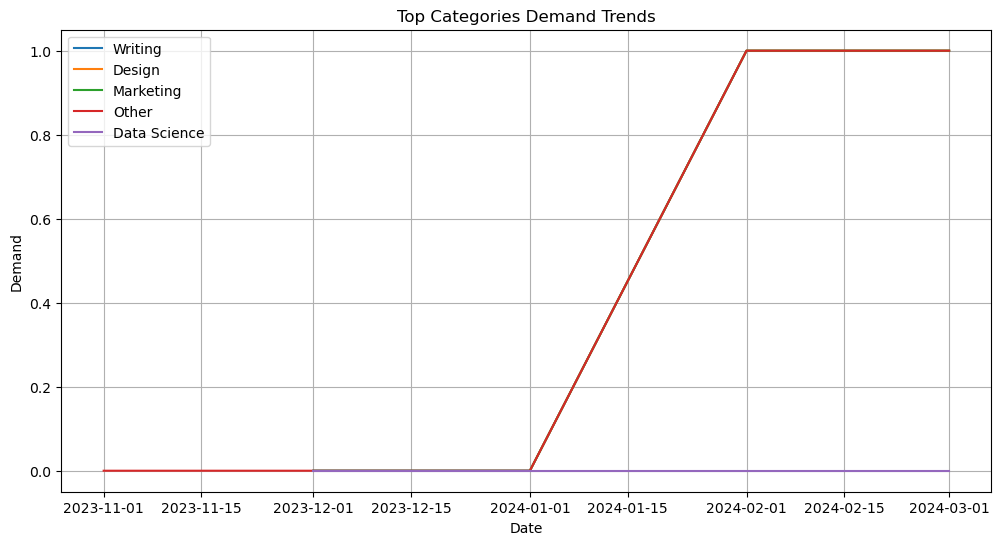

In [56]:
time_index = pd.to_datetime(demand_trends.index)

# Plot the data
plt.figure(figsize=(12, 6))
for category in top_categories:
    plt.plot(time_index, demand_trends[category], label=category)

plt.title('Top Categories Demand Trends')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)
plt.show()

## Task 4: Geographic Salary Analysis

In [57]:
df['average_hourly_rate'] = df[['hourly_low', 'hourly_high']].mean(axis=1)

In [58]:
df_geo = df.loc[(df['average_hourly_rate'] > 0) & df['average_hourly_rate'].notna() & df['country'].notna()]

In [59]:
country_salary = df_geo.groupby('country').agg({'average_hourly_rate': 'mean'}).reset_index()
country_salary = country_salary.sort_values(by='average_hourly_rate', ascending=False)

In [60]:
import plotly.graph_objects as go

# Create a choropleth map using plotly.graph_objects
fig = go.Figure(go.Choropleth(
    locations=country_salary['country'],
    locationmode='country names',
    z=country_salary['average_hourly_rate'],
    colorscale='Plasma',
    colorbar_title='Hourly Rate (USD)',
    hovertemplate='<b>%{location}</b><br>Avg Hourly Rate: %{z}',
))

# Update layout for a more customized map
fig.update_layout(
    geo=dict(showframe=False, projection_type="natural earth"),
    title="Geographic Salary Analysis: Average Hourly Rates by Country",
    title_font_size=20,
)

fig.show()

In [61]:
# Display Top 10 countries with highest wages
print("Top 10 countries with highest wages:")
print(country_salary.nlargest(10, 'average_hourly_rate'))

# Display Bottom 10 countries with lowest wages
print("\nBottom 10 countries with lowest wages:")
print(country_salary.nsmallest(10, 'average_hourly_rate'))

Top 10 countries with highest wages:
                      country  average_hourly_rate
106                      Laos           155.125000
61                    Eritrea            61.250000
195  Turks and Caicos Islands            46.625000
115                    Malawi            42.375000
135      Netherlands Antilles            35.416667
109             Liechtenstein            35.000000
68              French Guiana            34.000000
116                  Malaysia            31.661130
188                  Thailand            30.319061
29     British Virgin Islands            29.145833

Bottom 10 countries with lowest wages:
                                  country  average_hourly_rate
38               Central African Republic             5.000000
207                               Vanuatu             6.500000
65                                   Fiji            15.833333
30                      Brunei Darussalam            15.875000
139                                 Niger      

## Task 5: Personalized Job Recommendation System

In [62]:
df['job_description'] = df['title'] + " " + df['country'] + " " + df['is_hourly'].astype(str)

In [63]:
df['job_description'] = df['job_description'].fillna('')

In [64]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
job_vectors = vectorizer.fit_transform(df['job_description'])

In [65]:
with open("tfidf_model.pkl", "wb") as file:
    pickle.dump(vectorizer, file)

In [66]:
user_profile = {
    'preferred_title': 'Data Scientist',
    'preferred_country': 'United States',
    'preferred_hourly': True
}

In [67]:
# Using f-strings for string concatenation
user_vector_input = f"{user_profile['preferred_title']} {user_profile['preferred_country']} {user_profile['preferred_hourly']}"
user_vector = vectorizer.transform([user_vector_input])

In [68]:
similarity_scores = cosine_similarity(user_vector, job_vectors).flatten()

In [69]:
df['similarity_score'] = similarity_scores

In [70]:
top_recommendations = df.nlargest(10, 'similarity_score')
print("Top 10 Job Recommendations:")
print(top_recommendations[['title', 'country', 'similarity_score']])

Top 10 Job Recommendations:
                 title         country  similarity_score
20017   Data Scientist   United States          1.000000
52859   Data Scientist   United States          1.000000
99592   Data Scientist   United States          1.000000
192080  Data Scientist   United States          1.000000
217927  Data Scientist   United States          1.000000
236871  Data Scientist   United States          1.000000
14460   Data Scientist   United States          0.969423
44791   Data Scientist   United States          0.969423
174846  Data Scientist   United States          0.969423
101541  Data Scientist  United Kingdom          0.919806


In [71]:
from pathlib import Path

file_path = Path(r"C:\Users\NITESH NAMDEV\Nexthike projects\Project_8  Dynamic Workforce Insights and Recommendation Platform") / 'Job Listings.csv'
df.to_csv(file_path, index=False)

## Task 7: Remote Work Trends Analysis

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244827 entries, 0 to 244827
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   title                244827 non-null  object             
 1   link                 244827 non-null  object             
 2   published_date       244827 non-null  datetime64[ns, UTC]
 3   is_hourly            244827 non-null  bool               
 4   hourly_low           244827 non-null  float64            
 5   hourly_high          244827 non-null  float64            
 6   budget               244827 non-null  float64            
 7   country              244827 non-null  object             
 8   Cleaned Job Title    244827 non-null  object             
 9   Category             244827 non-null  object             
 10  YearMonth            244827 non-null  object             
 11  average_hourly_rate  244827 non-null  float64            
 12  jo

In [73]:
df['is_remote'] = df['job_description'].str.contains(
    'remote|work from home|telecommute|online', case=False, na=False
)

In [74]:
df['published_date'] = pd.to_datetime(df['published_date'])

# Extract Year-Month manually using datetime attributes
df['YearMonth'] = df['published_date'].dt.year.astype(str) + '-' + df['published_date'].dt.month.astype(str).str.zfill(2)

# Group by 'YearMonth' and calculate the percentage of remote jobs
monthly_remote_trends = df.groupby('YearMonth')['is_remote'].mean() * 100

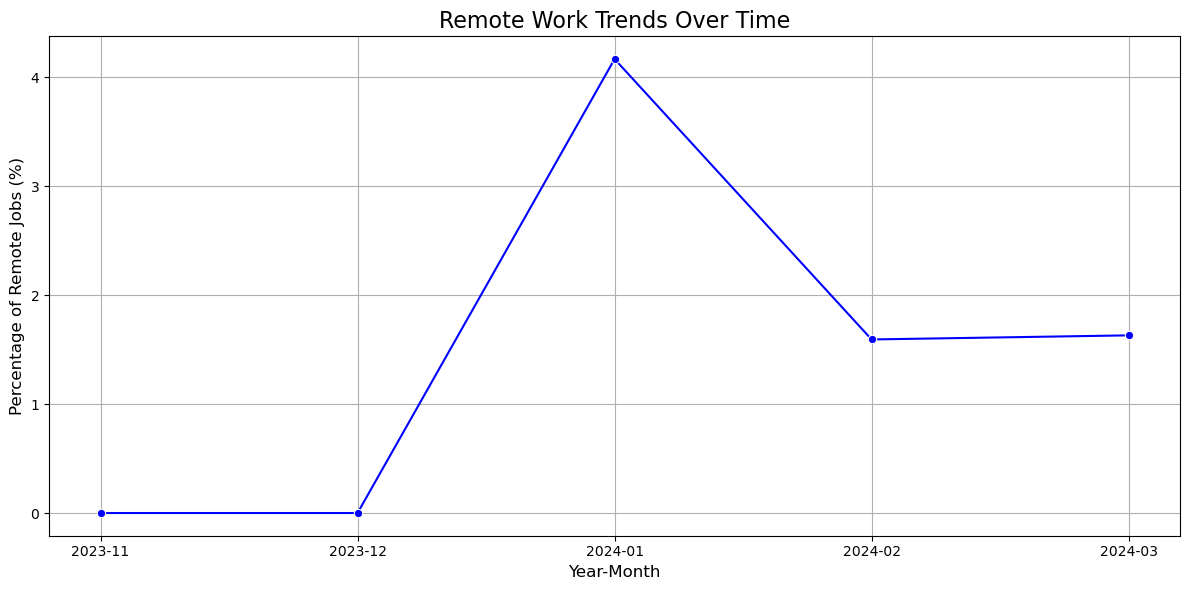

In [75]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_remote_trends.index, y=monthly_remote_trends.values, marker='o', color='blue')
plt.title("Remote Work Trends Over Time", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Percentage of Remote Jobs (%)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("remote_work_trends_seaborn.png")
plt.show()

In [77]:
monthly_remote_trends_df = monthly_remote_trends.reset_index()

# Convert 'YearMonth' to timestamp and then to ordinal for regression
monthly_remote_trends_df['YearMonth_num'] = pd.to_datetime(monthly_remote_trends_df['YearMonth'].astype(str)).apply(lambda x: x.toordinal())

X = monthly_remote_trends_df[['YearMonth_num']]
y = monthly_remote_trends_df['is_remote']

In [78]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [79]:
last_date = df['published_date'].max()
future_dates = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(), periods=12, freq='M'
)
future_dates_ordinal = future_dates.map(lambda x: x.toordinal()).values.reshape(-1, 1)
future_predictions = model.predict(future_dates_ordinal)

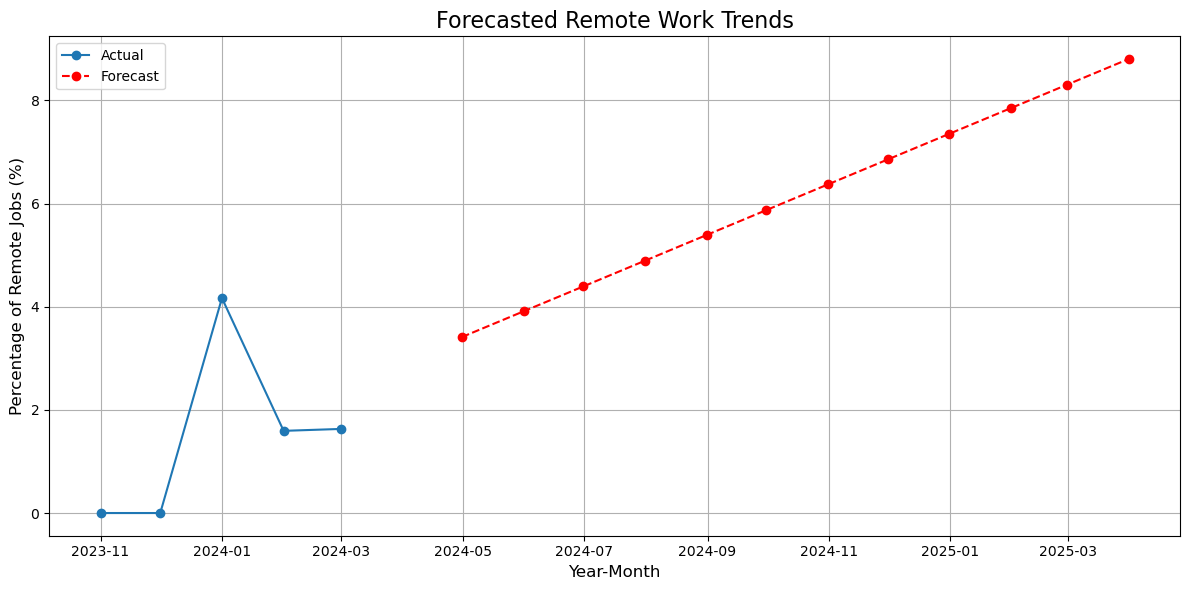

In [80]:
# Convert PeriodIndex to datetime explicitly
dates = pd.to_datetime(monthly_remote_trends.index.astype(str))

plt.figure(figsize=(12, 6)) 
plt.plot(dates, monthly_remote_trends, marker='o', label="Actual")

# Assuming future_dates and future_predictions are defined
# Convert future_dates to datetime if they are in Period format
future_dates = pd.to_datetime(future_dates)

plt.plot(future_dates, future_predictions, linestyle='--', marker='o', color='red', label="Forecast")
plt.title("Forecasted Remote Work Trends", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Percentage of Remote Jobs (%)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("forecasted_remote_work_trends.png")
plt.show()

In [81]:
remote_rate = df['is_remote'].mean() * 100
print(f"Overall Remote Work Rate: {remote_rate:.2f}%")

recent_trends = monthly_remote_trends.tail(12)
forecasted_trends = dict(zip(future_dates.strftime('%Y-%m'), future_predictions))

print("\nRecent Monthly Trends:")
print(recent_trends)

print("\nForecasted Trends:")
for date, prediction in forecasted_trends.items():
    print(f"{date}: {prediction:.2f}%")

Overall Remote Work Rate: 1.62%

Recent Monthly Trends:
YearMonth
2023-11    0.000000
2023-12    0.000000
2024-01    4.166667
2024-02    1.592957
2024-03    1.630564
Name: is_remote, dtype: float64

Forecasted Trends:
2024-04: 3.41%
2024-05: 3.91%
2024-06: 4.39%
2024-07: 4.89%
2024-08: 5.39%
2024-09: 5.87%
2024-10: 6.37%
2024-11: 6.85%
2024-12: 7.35%
2025-01: 7.85%
2025-02: 8.30%
2025-03: 8.80%


In [82]:
# Calculate overall remote work rate
remote_rate = df['is_remote'].mean() * 100
print(f"Overall Remote Work Rate: {remote_rate:.2f}%")

# Get the recent 12 months of remote work trends
recent_trends = monthly_remote_trends.iloc[-12:]

forecasted_trends = {date.strftime('%Y-%m'): prediction for date, prediction in zip(future_dates, future_predictions)}

print("\nRecent Monthly Trends:")
for date, trend in recent_trends.items():
    print(f"{date}: {trend:.2f}%")

print("\nForecasted Trends:")
for date, prediction in forecasted_trends.items():
    print(f"{date}: {prediction:.2f}%")

Overall Remote Work Rate: 1.62%

Recent Monthly Trends:
2023-11: 0.00%
2023-12: 0.00%
2024-01: 4.17%
2024-02: 1.59%
2024-03: 1.63%

Forecasted Trends:
2024-04: 3.41%
2024-05: 3.91%
2024-06: 4.39%
2024-07: 4.89%
2024-08: 5.39%
2024-09: 5.87%
2024-10: 6.37%
2024-11: 6.85%
2024-12: 7.35%
2025-01: 7.85%
2025-02: 8.30%
2025-03: 8.80%


In [83]:
report = f"""
Remote Work Trends Analysis Report
==================================
Overall Remote Work Rate: {remote_rate:.2f}%

Recent Monthly Trends:
{recent_trends}

Forecasted Remote Work Trends:
{"-"*40}
Month            Forecasted Remote Job Rate (%)
{"-"*40}
""" + "\n".join([f"{date}: {prediction:.2f}%" for date, prediction in forecasted_trends.items()])

with open("remote_work_trends_report.txt", "w") as file:
    file.write(report)

print("\nReport saved as 'remote_work_trends_report.txt'")


Report saved as 'remote_work_trends_report.txt'


In [84]:
# Create report content
report = []
report.append("Remote Work Trends Analysis Report")
report.append("="*34)
report.append(f"Overall Remote Work Rate: {remote_rate:.2f}%")
report.append("")
report.append("Recent Monthly Trends:")
report.append(str(recent_trends))  # Display recent trends as a string
report.append("")
report.append("Forecasted Remote Work Trends:")
report.append("-" * 40)
report.append("Month            Forecasted Remote Job Rate (%)")
report.append("-" * 40)

# Append forecasted trends
for date, prediction in forecasted_trends.items():
    report.append(f"{date}: {prediction:.2f}%")

# Write to file
with open("remote_work_trends_report.txt", "w") as file:
    file.write("\n".join(report))

# Notify user
print("\nReport saved as 'Remote Employment Trends Overview.txt'")



Report saved as 'Remote Employment Trends Overview.txt'


## Task 8: Future Workforce Trends Prediction

In [85]:
df.groupby('YearMonth').size()

YearMonth
2023-11         1
2023-12        10
2024-01        96
2024-02    101886
2024-03    142834
dtype: int64

In [86]:
df.head(5)

title  \
0  Experienced Media Buyer For Solar Pannel and R...   
1                               Full Stack Developer   
2                                    SMMA Bubble App   
3             Talent Hunter Specialized in Marketing   
4                                      Data Engineer   

                                                link  \
0  https://www.upwork.com/jobs/Experienced-Media-...   
1  https://www.upwork.com/jobs/Full-Stack-Develop...   
2  https://www.upwork.com/jobs/SMMA-Bubble-App_%7...   
3  https://www.upwork.com/jobs/Talent-Hunter-Spec...   
4  https://www.upwork.com/jobs/Data-Engineer_%7E0...   

             published_date  is_hourly  hourly_low  hourly_high  budget  \
0 2024-02-17 09:09:54+00:00      False        15.0         30.0   500.0   
1 2024-02-17 09:09:17+00:00      False        15.0         30.0  1100.0   
2 2024-02-17 09:08:46+00:00       True        10.0         30.0    20.0   
3 2024-02-17 09:08:08+00:00       True        15.0         30.0    22.5   
4 2024-02-17 09:07:42+00:00      False        15.0         30.0   650.0   

         country                                  Cleaned Job Title  \
0        Unknown  experienced media buyer solar pannel roofing i...   
1  United States                               full stack developer   
2  United States                                    smma bubble app   
3  United States                talent hunter specialized marketing   
4          India                                      data engineer   

               Category YearMonth  average_hourly_rate  \
0                 Other   2024-02                 22.5   
1  Software Development   2024-02                 22.5   
2                 Other   2024-02                 20.0   
3             Marketing   2024-02                 22.5   
4  Software Development   2024-02                 22.5   

                                     job_description  similarity_score  \
0  Experienced Media Buyer For Solar Pannel and R...          0.000000   
1           Full Stack Developer United States False          0.088332   
2                 SMMA Bubble App United States True          0.070677   
3  Talent Hunter Specialized in Marketing United ...          0.056631   
4                          Data Engineer India False          0.258671   

   is_remote  
0      False  
1      False  
2      False  
3      False  
4      False

In [87]:
monthly_data = df.groupby('YearMonth').apply(
    lambda group: pd.Series({
        'is_remote': group['is_remote'].sum(),
        'budget': group['budget'].mean(),
        'average_hourly_rate': group['average_hourly_rate'].mean(),
        'total_jobs': group['title'].count()
    })
).reset_index()

In [88]:
monthly_data

YearMonth  is_remote      budget  average_hourly_rate  total_jobs
0   2023-11        0.0   37.500000            37.500000         1.0
1   2023-12        0.0   96.050000            25.550000        10.0
2   2024-01        4.0  124.786458            22.630208        96.0
3   2024-02     1623.0  394.518452            25.586572    101886.0
4   2024-03     2329.0  408.635826            25.275792    142834.0

In [89]:
# Convert YearMonth to Period first if it's not already in Period format
monthly_data['YearMonth'] = pd.to_datetime(monthly_data['YearMonth'], format='%Y-%m').dt.to_period('M')

# Now convert the Period to Timestamp and set as index
monthly_data['YearMonth'] = monthly_data['YearMonth'].apply(lambda x: x.start_time)
monthly_data.set_index('YearMonth', inplace=True)

In [90]:
print(str(monthly_data.head()))

            is_remote      budget  average_hourly_rate  total_jobs
YearMonth                                                         
2023-11-01        0.0   37.500000            37.500000         1.0
2023-12-01        0.0   96.050000            25.550000        10.0
2024-01-01        4.0  124.786458            22.630208        96.0
2024-02-01     1623.0  394.518452            25.586572    101886.0
2024-03-01     2329.0  408.635826            25.275792    142834.0


In [91]:
import plotly.express as px

# Create an interactive plot for each column
fig = px.line(monthly_data, facet_col='variable', facet_col_wrap=3)
fig.update_layout(title="Job Market Trends")
fig.show()

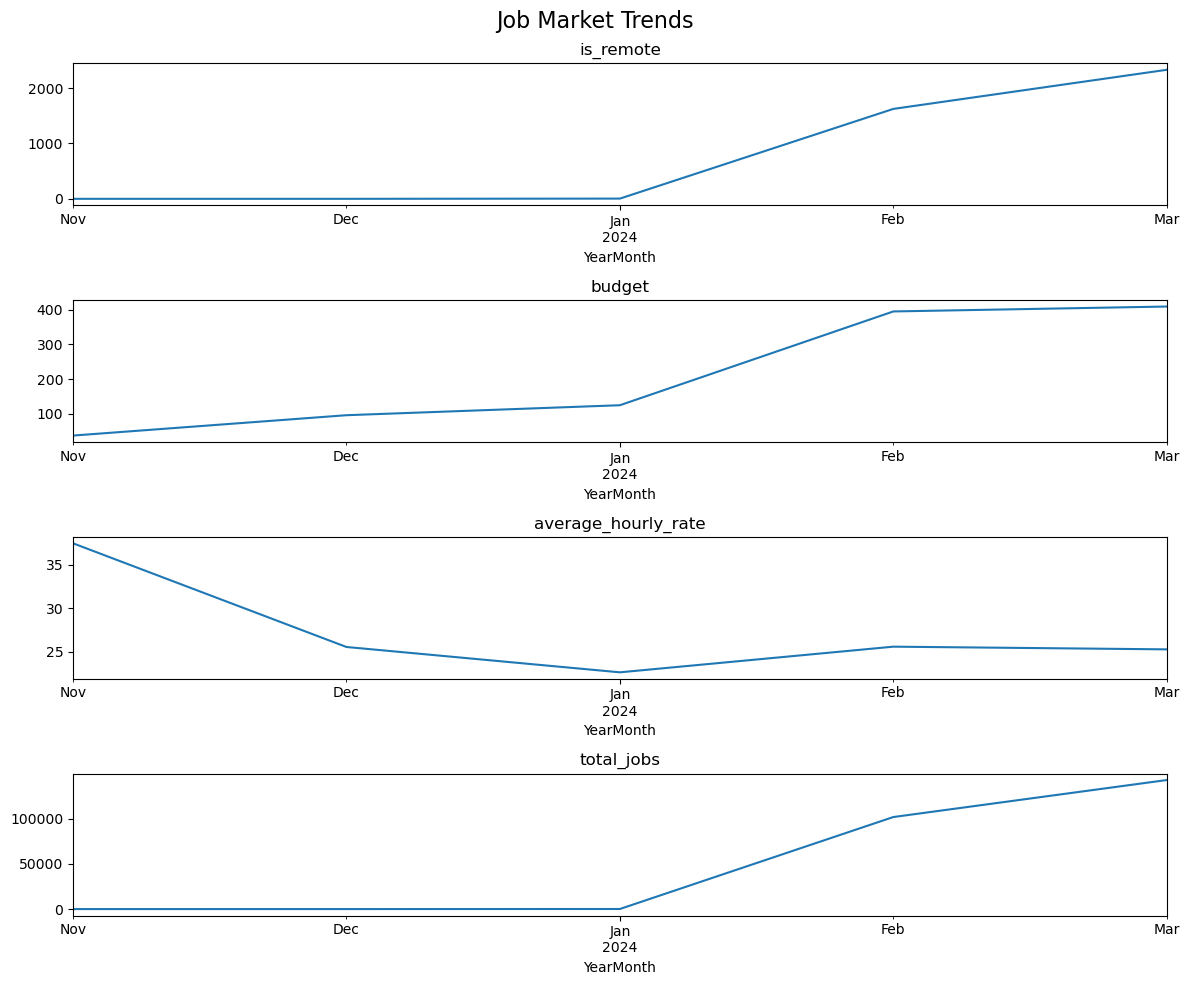

In [92]:
fig, axes = plt.subplots(nrows=len(monthly_data.columns), figsize=(12, 10))
fig.suptitle("Job Market Trends", fontsize=16)

for i, column in enumerate(monthly_data.columns):
    monthly_data[column].plot(ax=axes[i], title=column)

plt.tight_layout()
plt.show()

In [93]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model to the total_jobs column
arima_model = ARIMA(monthly_data['total_jobs'], order=(1, 1, 1))
arima_result = arima_model.fit()

# Summary of the fitted model
print(arima_result.summary())

C:\Users\NITESH NAMDEV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\NITESH NAMDEV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\NITESH NAMDEV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:             total_jobs   No. Observations:                    5
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -49.209
Date:                Thu, 12 Dec 2024   AIC                            104.417
Time:                        21:09:29   BIC                            102.576
Sample:                    11-01-2023   HQIC                           100.377
                         - 03-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4026   1.05e+04   3.83e-05      1.000   -2.06e+04    2.06e+04
ma.L1          0.0005   1.05e+04   4.48e-08      1.000   -2.06e+04    2.06e+04
sigma2      1.734e+09   1.85e+09      0.938      0.3

In [94]:
future_steps = 12  # Predict for the next year
forecast_arima = arima_result.forecast(steps=future_steps)
forecast_arima.index = pd.date_range(start=monthly_data.index[-1], periods=future_steps + 1, freq='M')[1:]

In [95]:
from pmdarima import auto_arima

# Fit the model using auto_arima (if not already done)
auto_arima_model = auto_arima(monthly_data['total_jobs'], seasonal=False, trace=True)
future_steps = 12

# Forecast the next 12 months
forecast_arima = auto_arima_model.predict(n_periods=future_steps)

# Create the forecast index for the next 12 months
forecast_index = pd.date_range(start=monthly_data.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')

# Assign the forecasted values to the new index
forecast_arima_series = pd.Series(forecast_arima, index=forecast_index)

print(forecast_arima_series)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=128.893, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=128.038, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=133.553, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=129.773, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.227 seconds
2024-04-30   NaN
2024-05-31   NaN
2024-06-30   NaN
2024-07-31   NaN
2024-08-31   NaN
2024-09-30   NaN
2024-10-31   NaN
2024-11-30   NaN
2024-12-31   NaN
2025-01-31   NaN
2025-02-28   NaN
2025-03-31   NaN
Freq: M, dtype: float64


In [96]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Fit Simple Exponential Smoothing model
model = SimpleExpSmoothing(monthly_data['total_jobs'])
fitted_model = model.fit()

# Predict the next 12 steps (future months)
future_steps = 12
forecast_expo = fitted_model.forecast(future_steps)

# Create forecast index for the next 12 months
forecast_index = pd.date_range(start=monthly_data.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')

# Assign the forecasted values to the new index
forecast_expo_series = pd.Series(forecast_expo, index=forecast_index)

print(forecast_expo_series)

2024-04-30   NaN
2024-05-31   NaN
2024-06-30   NaN
2024-07-31   NaN
2024-08-31   NaN
2024-09-30   NaN
2024-10-31   NaN
2024-11-30   NaN
2024-12-31   NaN
2025-01-31   NaN
2025-02-28   NaN
2025-03-31   NaN
Freq: M, dtype: float64


C:\Users\NITESH NAMDEV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\NITESH NAMDEV\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



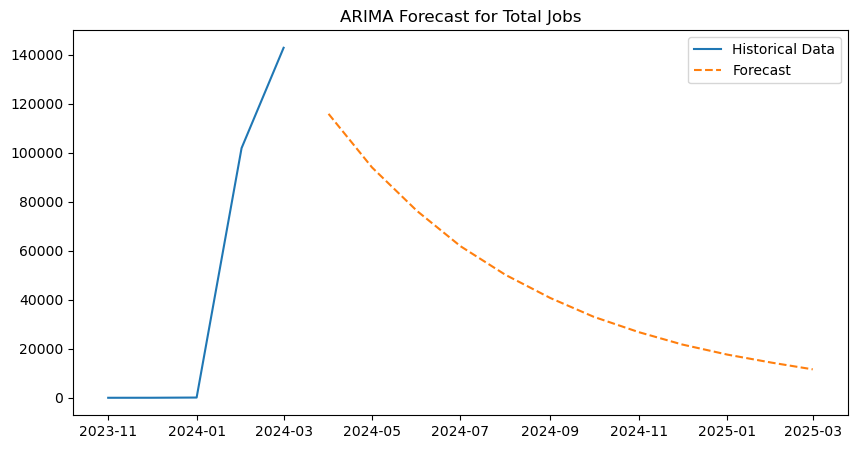

In [97]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_data['total_jobs'], label='Historical Data')
plt.plot(forecast_arima, label='Forecast', linestyle='--')
plt.title('ARIMA Forecast for Total Jobs')
plt.legend()
plt.show()

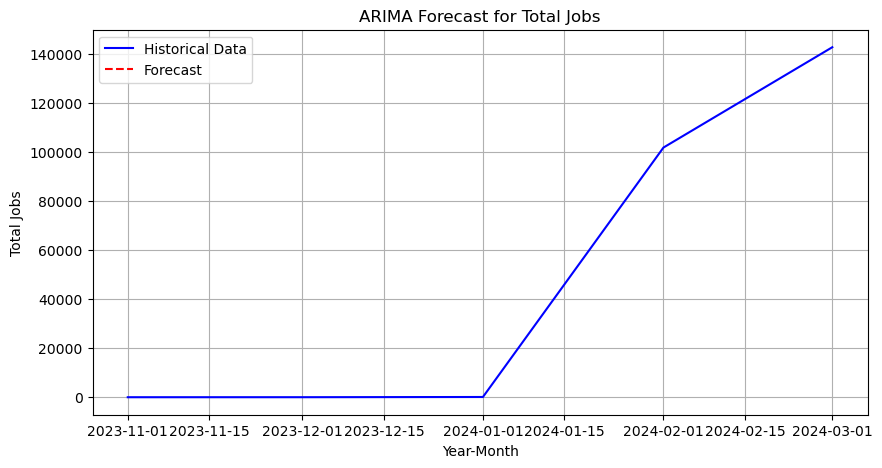

In [98]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_data['total_jobs'], label='Historical Data', color='blue')
plt.plot(forecast_arima_series, label='Forecast', linestyle='--', color='red')
plt.title('ARIMA Forecast for Total Jobs')
plt.xlabel('Year-Month')
plt.ylabel('Total Jobs')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
import plotly.graph_objects as go

# Create traces for historical data and forecast
historical_trace = go.Scatter(x=monthly_data.index, y=monthly_data['total_jobs'], mode='lines', name='Historical Data')
forecast_trace = go.Scatter(x=forecast_arima_series.index, y=forecast_arima_series, mode='lines', name='Forecast', line=dict(dash='dash'))

# Combine the traces
fig = go.Figure(data=[historical_trace, forecast_trace])

# Add title and labels
fig.update_layout(
    title='ARIMA Forecast for Total Jobs',
    xaxis_title='Year-Month',
    yaxis_title='Total Jobs',
    legend_title='Data Type'
)

# Show the figure
fig.show()

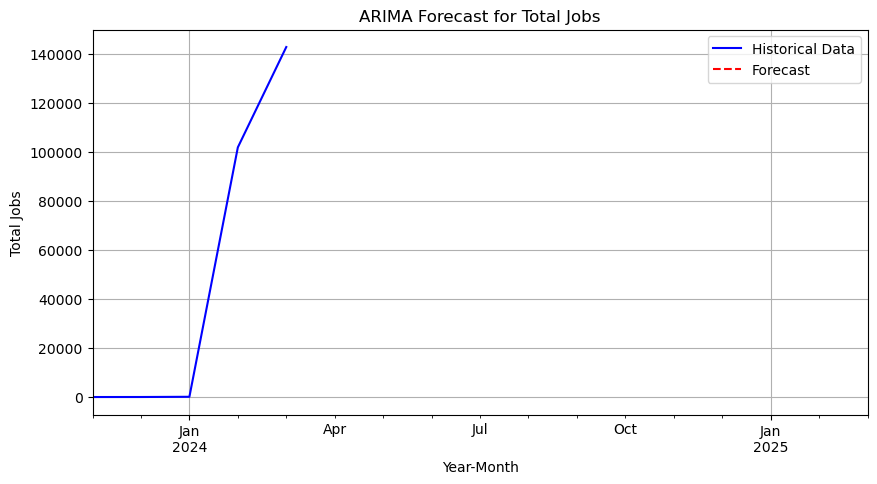

In [100]:
plt.figure(figsize=(10, 5))
monthly_data['total_jobs'].plot(label='Historical Data', color='blue')
forecast_arima_series.plot(label='Forecast', linestyle='--', color='red')

# Add title and labels
plt.title('ARIMA Forecast for Total Jobs')
plt.xlabel('Year-Month')
plt.ylabel('Total Jobs')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
prophet_data = monthly_data.reset_index()[['YearMonth', 'is_remote']].rename(columns={'YearMonth': 'ds', 'is_remote': 'y'})

In [102]:
prophet_model = Prophet()
prophet_model = prophet_model.fit(prophet_data)

21:09:38 - cmdstanpy - INFO - Chain [1] start processing
21:09:38 - cmdstanpy - INFO - Chain [1] done processing


In [103]:
future_dates = prophet_model.make_future_dataframe(periods=future_steps, freq='M')
forecast_prophet = prophet_model.predict(future_dates)

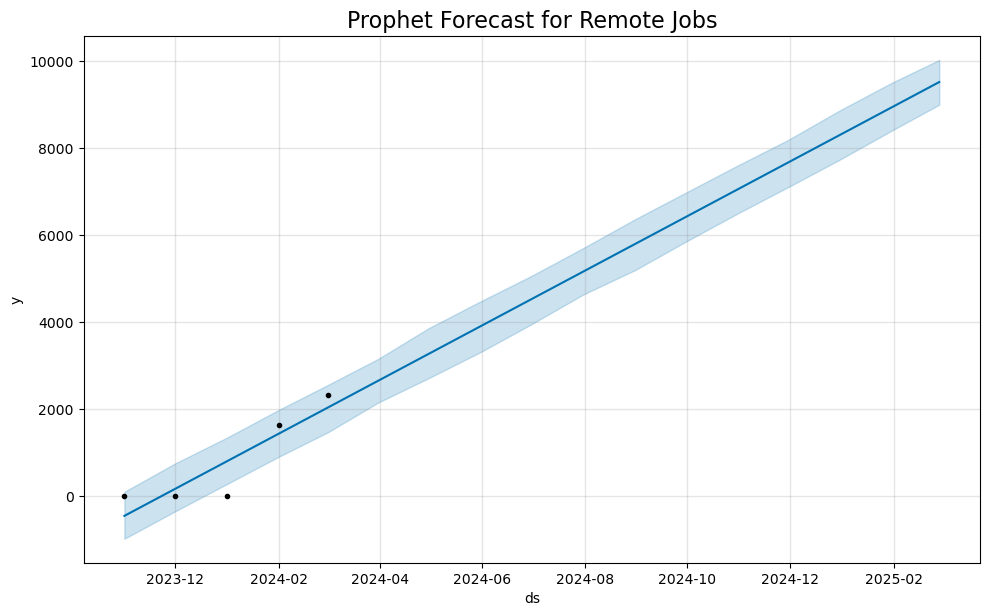

In [104]:
fig = prophet_model.plot(forecast_prophet)
fig.axes[0].set_title('Prophet Forecast for Remote Jobs', fontsize=16)
plt.show()

In [105]:
y_true = monthly_data.iloc[-5:]['total_jobs']

# Generate predicted values using ARIMA with explicit index range
y_pred_arima = arima_result.predict(
    start=monthly_data.index[-5], 
    end=monthly_data.index[-1]
)

In [106]:
# Calculate RMSE manually
rmse_arima = np.sqrt(np.mean((y_true - y_pred_arima) ** 2))

# Calculate MAPE manually
mape_arima = np.mean(np.abs((y_true - y_pred_arima) / y_true)) * 100

# Print results
print(f"ARIMA RMSE: {rmse_arima:.2f}")
print(f"ARIMA MAPE: {mape_arima:.2f}%")

ARIMA RMSE: 45506.40
ARIMA MAPE: 74.34%
